# Compare BERT and SVM with MLP models of all datasets

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import os

In [42]:
import pandas as pd

def load_all_results():
    file_map = {
        'No Punc': "../../../notebooks/artifacts/no_punctuation/test_results.csv",
        'No Punc/Stop': "../../../notebooks/artifacts/no_punctuation_no_stop_words/test_results.csv",
        'Punc': "../../../notebooks/artifacts/punctuation/test_results.csv",
        'Punc/Stop': "../../../notebooks/artifacts/punctuation_no_stop_words/test_results.csv",
        'N-Grams': "../artifacts/ngrams/test_results.csv",
        'Lemmatization': "../artifacts/lemmatization/test_results.csv",
        'SVM': "../artifacts/svm/test_results.csv",
        'BERT': "../artifacts/bert/models/test_results.csv"
    }
    
    all_dfs = []
    
    for label, path in file_map.items():
        temp_df = pd.read_csv(path)
        target_model = 'BERT-PC' if label == 'BERT' else 'MLP'
        filtered_df = temp_df[temp_df['Unnamed: 0'] == target_model].copy()
        filtered_df['Preprocessing'] = label
        all_dfs.append(filtered_df)

    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df = combined_df.rename(columns={'Unnamed: 0': 'Model'})
    
    metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    for metric in metrics:
        combined_df[metric] = pd.to_numeric(combined_df[metric], errors='coerce')
    
    return combined_df.dropna(subset=['accuracy'])

df = load_all_results()

df_melted = df.melt(id_vars=['Model', 'Preprocessing'], 
                    value_vars=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                    var_name='Metric', 
                    value_name='Score')

df_melted['Metric'] = df_melted['Metric'].replace({
    'accuracy': 'Accuracy',
    'precision_macro': 'Precision',
    'recall_macro': 'Recall',
    'f1_macro': 'F1 Score'
})

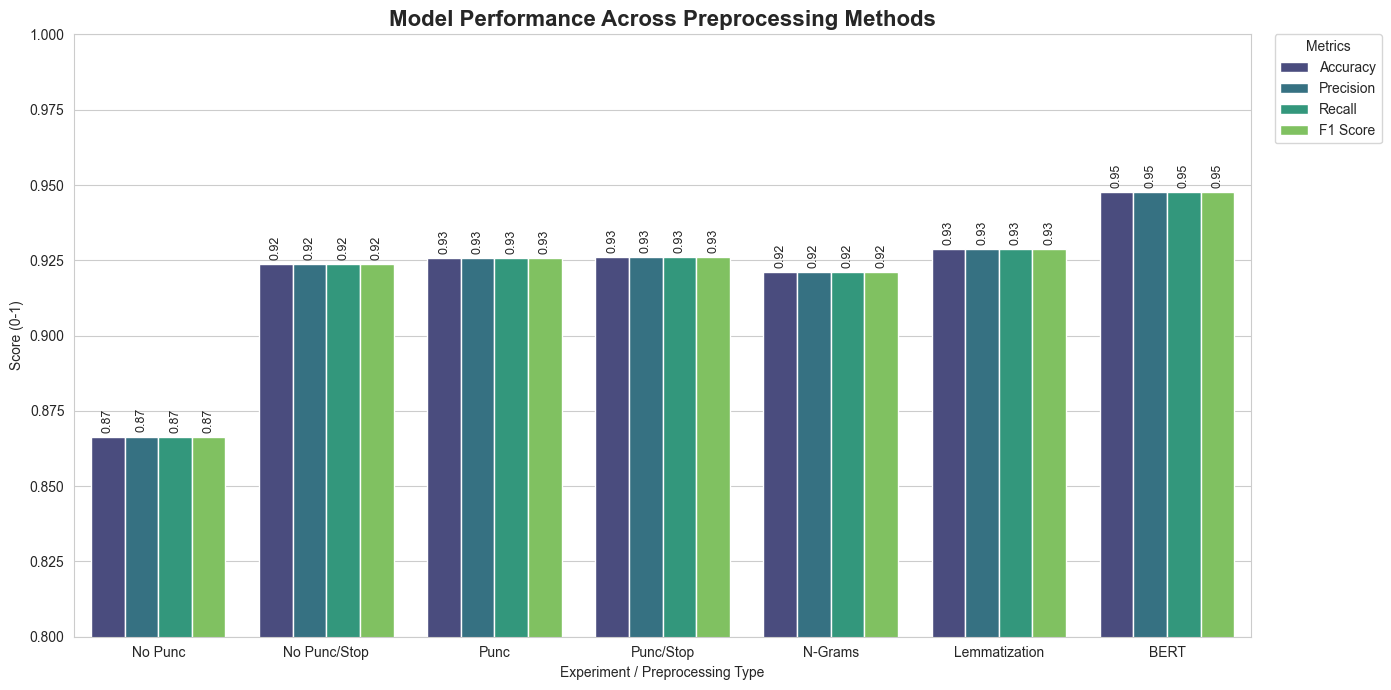

In [43]:
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

plot = sns.barplot(
    data=df_melted, 
    x="Preprocessing", 
    y="Score", 
    hue="Metric", 
    palette="viridis"
)

# Formatting
plt.title("Model Performance Across Preprocessing Methods", fontsize=16, fontweight='bold')
plt.ylim(0.8, 1.0)
plt.ylabel("Score (0-1)")
plt.xlabel("Experiment / Preprocessing Type")

plt.legend(title="Metrics", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

for container in plot.containers:
    plot.bar_label(container, fmt='%.2f', padding=3, fontsize=9, rotation=90)

plt.tight_layout()
plt.show()

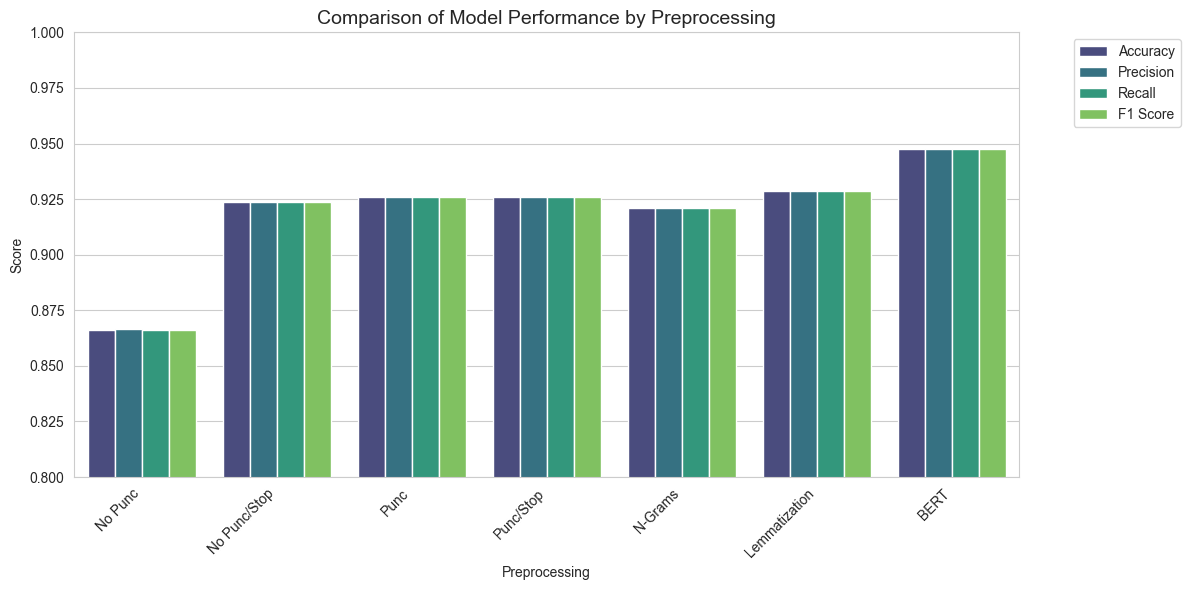

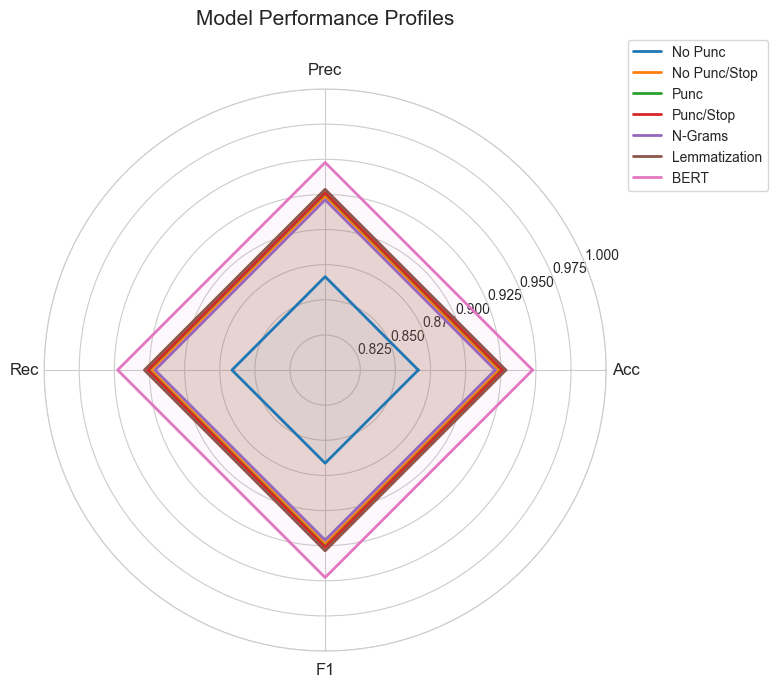

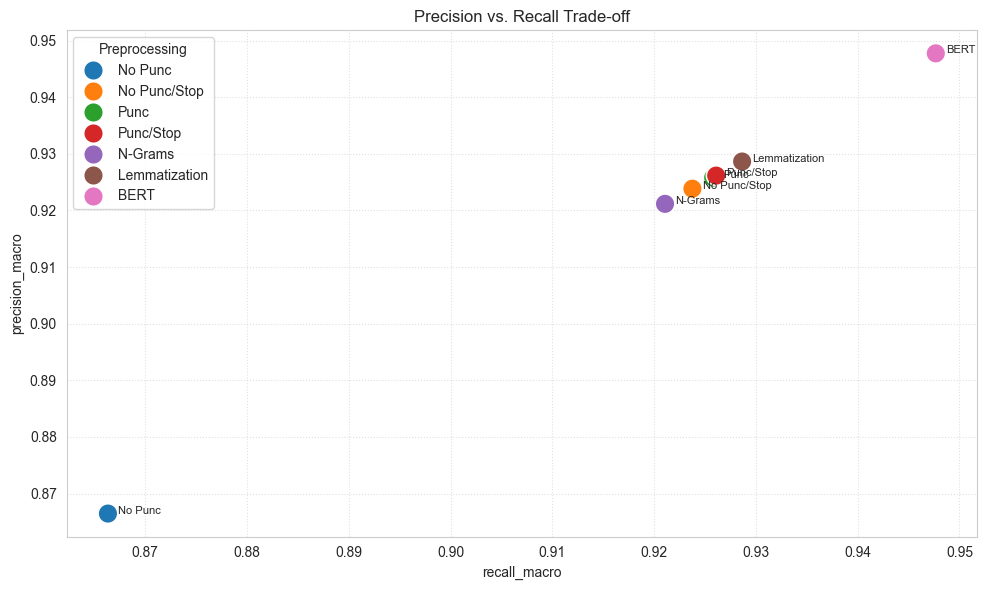

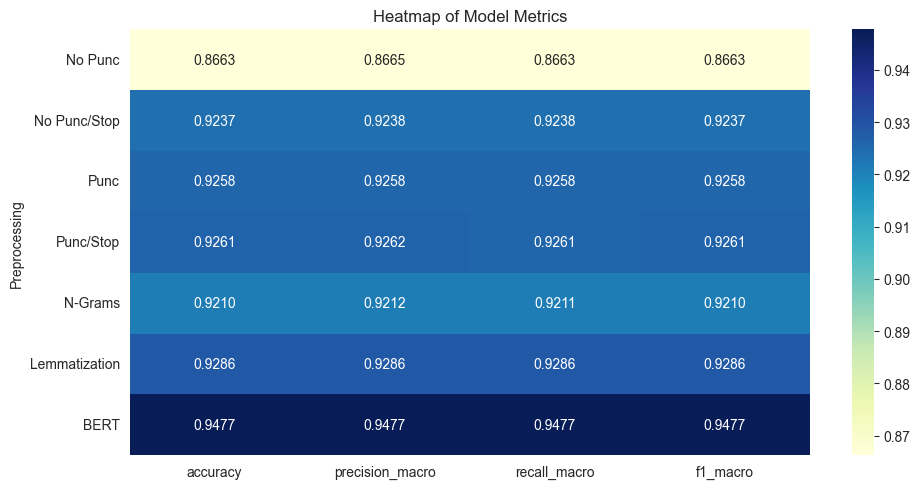

In [44]:
output_dir = '../../assets/best_dataset_models_comparison/'
os.makedirs(output_dir, exist_ok=True)
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# --- GRAPH 1: Grouped Bar Chart ---
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(data=df_melted, x='Preprocessing', y='Score', hue='Metric', palette='viridis')
plt.title('Comparison of Model Performance by Preprocessing', fontsize=14)
plt.ylim(0.8, 1.0) 
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'{output_dir}grouped_bar_chart.png')

# --- GRAPH 2: Radar Chart ---
def create_radar_chart(df, metrics):
    categories = ['Acc', 'Prec', 'Rec', 'F1'] # Shorter labels for radar
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    for i, row in df.iterrows():
        values = row[metrics].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=row['Preprocessing'])
        ax.fill(angles, values, alpha=0.05)
    
    plt.xticks(angles[:-1], categories, size=12)
    plt.ylim(0.8, 1.0)
    plt.title('Model Performance Profiles', size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.savefig(f'{output_dir}radar_chart.png')

create_radar_chart(df, metrics)

# --- GRAPH 3: Precision-Recall Scatter ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='recall_macro', y='precision_macro', hue='Preprocessing', s=200)
for i in range(df.shape[0]):
    plt.text(df.recall_macro.iloc[i]+0.001, df.precision_macro.iloc[i], df.Preprocessing.iloc[i], fontsize=8)
plt.title('Precision vs. Recall Trade-off')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig(f'{output_dir}precision_recall_scatter.png')

# --- GRAPH 4: Heatmap ---
plt.figure(figsize=(10, 5))
# Use Experiment as index so each row is unique
heatmap_data = df.set_index('Preprocessing')[metrics]
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.4f')
plt.title('Heatmap of Model Metrics')
plt.tight_layout()
plt.savefig(f'{output_dir}performance_heatmap.png')

plt.show()